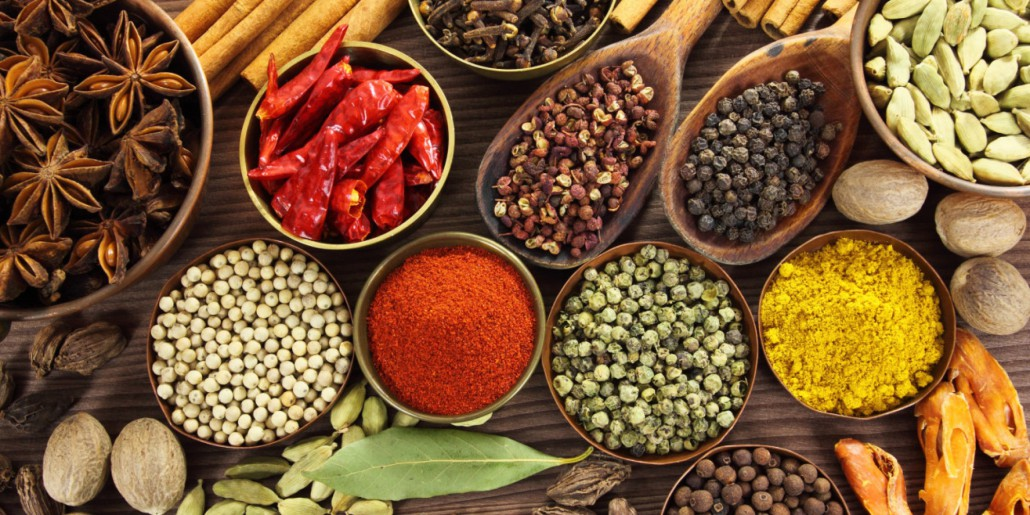

# Capstone Project: Restaurant Market Basket Analysis
# Part III - Data Modeling
## by Dana Smart

<br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#by-Dana-Smart" data-toc-modified-id="by-Dana-Smart-1">by Dana Smart</a></span></li><li><span><a href="#1.-Defining-Market-Basket-Analysis" data-toc-modified-id="1.-Defining-Market-Basket-Analysis-2">1. Defining Market Basket Analysis</a></span><ul class="toc-item"><li><span><a href="#1.1-Grouping-Items-Within-Transaction-Together" data-toc-modified-id="1.1-Grouping-Items-Within-Transaction-Together-2.1">1.1 Grouping Items Within Transaction Together</a></span></li><li><span><a href="#1.2-The-Plan" data-toc-modified-id="1.2-The-Plan-2.2">1.2 The Plan</a></span></li></ul></li><li><span><a href="#2.-Encode-the-Item_Name-Column" data-toc-modified-id="2.-Encode-the-Item_Name-Column-3">2. Encode the Item_Name Column</a></span></li><li><span><a href="#3.-Apriori-Algorithm" data-toc-modified-id="3.-Apriori-Algorithm-4">3. Apriori Algorithm</a></span></li><li><span><a href="#4.-Determine-Association-Rules" data-toc-modified-id="4.-Determine-Association-Rules-5">4. Determine Association Rules</a></span><ul class="toc-item"><li><span><a href="#Applying-the-Apriori-algorithm-with-different-thresholds" data-toc-modified-id="Applying-the-Apriori-algorithm-with-different-thresholds-5.1">Applying the Apriori algorithm with different thresholds</a></span></li></ul></li></ul></div>

In [89]:
# Import the packages needed for our project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [90]:
# Load the csv file we saved in the previous notebook
orders_df = pd.read_csv('cleaned_data.csv', sep=',')

In [91]:
# Convert date type to datetime format
orders_df['Order_Date'] = pd.to_datetime(orders_df['Order_Date'])

In [92]:
# Check that we can read the data
orders_df.head()

,Unnamed: 0,Order_ID,Order_Date,Item_Name,Quantity,Product_Price,Total_products,Year,Month,Day_of_Month,Hour,Day_of_Week
0,0,25583,2019-03-08 21:58:00,Tandoori Mixed Grill,1,11.95,12,2019,3,8,21,Friday
1,1,25583,2019-03-08 21:58:00,Madras Sauce,1,3.95,12,2019,3,8,21,Friday
2,2,25583,2019-03-08 21:58:00,Mushroom Rice,2,3.95,12,2019,3,8,21,Friday
3,3,25583,2019-03-08 21:58:00,Garlic Naan,1,2.95,12,2019,3,8,21,Friday
4,4,25583,2019-03-08 21:58:00,Paratha,1,2.95,12,2019,3,8,21,Friday


<br>

## 1. Defining Market Basket Analysis

Before we proceed any further, let's learn more about market basket analysis!

The main idea of this approach is to find relationships between the items in a transaction. This is important for us because it provides us with insight into which items are doing well and can help us differentiate ourselves from other restaurants here in London. 

One of the most popular algorithms used for market basket analysis is the Apriori algorithm. There are other algorithms that are also commonly used for this kind of modeling but this is what we will be applying to our dataset. 

The Apriori algorithm makes an assumption: we only want to find the items sets that are frequently bought. That means that we can assume that if an item is frequently bought, this particular item must be frequent in all subsets. It also takes the assumption that the inverse is true, if an item is not frequently bought, all the supersets will also be infrequent. 

This assumption is important because we can make many association rules with all the items in our transactions. However, in order to gather only the significant associations, we exclude the infrequent itemsets with the use of different measures. We will take a closer look at these metrics further into the notebook.

### 1.1 Grouping Items Within Transaction Together

The fun part begins! Let's group the items that are within the same order together. Now that the data has been cleaned, we want to transform the format so that each row represents an `Order_Id`. This will give us the basket format that will enable us to apply the Apriori algorithm. 

We will be referring to each group of items as a 'basket' or 'itemset' interchangeably. To remember this, you can imagine placing an order on your favorite food delivery app. The order (or your basket) contains all the items you plan on ordering for yourself (and others).

In [93]:
# Group items within their respective order
my_baskets = orders_df.groupby(['Order_ID']).Item_Name.apply(list)
my_baskets

Order_ID
2096     [Keema Naan, Kulcha Naan, Plain Rice, Peshwari...
4487     [Mango Chutney, Onion Chutney, Mint Sauce, Lim...
4488     [Keema Naan, Mushroom Rice, Saag Paneer, Butte...
4489                    [Chapati, Vegetable Curry, Madras]
4490     [Mixed Raita, Tandoori Chicken, Lamb Chilli Ma...
                               ...                        
25579    [Madras - Chicken Tikka, Mini Bhaji, Plain Ric...
25580    [Tandoori Fish Karahi, Aloo Gobi, Plain Rice, ...
25581    [Saag Paneer, Chapati, Onion Bhaji, Pilau Rice...
25582    [Tandoori King Prawn Masala, Pilau Rice, Peshw...
25583    [Tandoori Mixed Grill, Madras Sauce, Mushroom ...
Name: Item_Name, Length: 19658, dtype: object

In each row, we have the list of items that are included in the order. For example, order 2096 contains Keema Naan, Kulcha Naan, Plain Rice and other items. As you can see, it's difficult to easily see each individual item in the order. Before we transform these baskets into an easier form to read, let's take a look at the number of items that are included in each order. 

In [94]:
# Check number of items in each basket
my_baskets_len = my_baskets.str.len()
my_baskets_len

Order_ID
2096      7
4487     10
4488      5
4489      3
4490      4
         ..
25579     4
25580     4
25581     5
25582     5
25583    12
Name: Item_Name, Length: 19658, dtype: int64

If we take the same example, order 2096 contains 7 items. 

In [95]:
# Let's check the minimum and maximum number of items within an order
print(my_baskets_len.min(), my_baskets_len.max())
print(f"Our smallest basket has {my_baskets_len.min()} item and the biggest basket has {my_baskets_len.max()} items.")

1 29
Our smallest basket has 1 item and the biggest basket has 29 items.


### 1.2 The Plan

The steps we're going to take are as follows:
* Transform the dataframe so that item name is a boolean value for each transaction
* Define the minimum support
* Apply the Apriori algorithm to the transformed data
* Generate association rules
* Interpret the results in the next and final notebook

## 2. Encode the Item_Name Column

For this step, I initially used the one-hot encoder to encode the Item_Name column. Once we learned about the transaction encoder I removed that code. 

To reiterate, we're going to use the TransactionEncoder from `mlxtend` package to transform the Item_name column. This is the encoder used for transaction data.

In [96]:
# Instantiate the encoder
te = TransactionEncoder()

# Fit to the dataset
orders = te.fit_transform(my_baskets)

# Convert to a dataframe
orders_df = pd.DataFrame(orders, columns=te.columns_)
orders_df.head()

,Achar Chicken,Achar Lamb,Aloo Brinjal,Aloo Chaat,Aloo Dupiaza,Aloo Gobi,Aloo Mithy,Aloo Peas,Bangon Hari Mirch,Bhindi Bhajee,...,Vindaloo - Chicken Tikka,Vindaloo - King Prawn,Vindaloo - Lamb,Vindaloo - Prawn,Vindaloo - chicken,Vindaloo - chicken-tikka,Vindaloo - king-prawn,Vindaloo - lamb,Vindaloo - prawn,Vindaloo Sauce
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [97]:
# Check Shape
orders_df.shape

(19658, 337)

The above is the result of the encoding. We have 19,658 rows, the same number of transactions and 337 columns, a column for each unique value in the `Item_Name` column. The items are listed in alphabetical order. Each column has a binary value, it will be labeled as "False" if that particular item was not included in the transaction and labeled as "True" is it was included.

For example, if we take a look at the row at index [0] we can say that 'Achar Chicken' was not purchased in that order.

<br>

## 3. Apriori Algorithm

Now the dataset is ready, it will be used as input into the Apriori algorithm. Before we take this step, let's talk more about the three different metrics we'll be be referring to: support, confidence and lift.

__Support__  
This metric can be explained as measuring the popularity of an itsemset. We ask the question - what are the proportion of orders where this particular itemset comes up? The equation is the number of times the item appears divided by the total number of transactions.

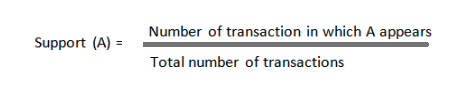

__Confidence__  
This metric is conditional and tells us the likelihood that the consequent, item B will be purchased if the antecedent, item A is purchased. The drawback of confidence is that we need to make sure that both items are not popular because they would lead to a high confidence. This is where the third metric comes in.

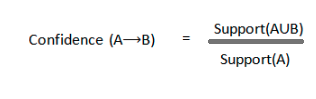

__Lift__  
Our third metric, unlike the confidence, takes into account the popularity of the consequent, item B. If lift > 1, it is probable that item B will be purchased with item A. This rule is referred to as the "strength of rule". 

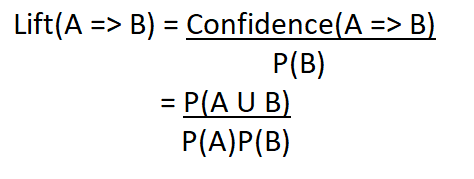

These are the steps we're going to take once we fit the Apriori algorithm to the data:
Step 1: Set threshold  
Step 2: Remove transaction that don;t meet the threshold, keep significant items only  
Step 3: Make all possible pairs (order does not matter)  
Step 4: Count the occurrences  

We are setting the min_support threshold to 0.05. This will filter out the itemsets that do not meet this threshold. We set the use_colnames to true that way we can identify the names of the items in the itemset. The alternative, by setting use_colnames to false, we would get the index of the item in the itemset. This would not be ideal to easily identify the frequent items that meet the threshold. 

Here we're asking the question, how many times do we find customers buying this group of items together? Can we find any patterns within our transactions?

In [98]:
# Apply Apriori algorithm to dataset
itemsets = apriori(orders_df, min_support=0.05, use_colnames=True)

In [99]:
# View results
itemsets.head()

,support,itemsets
0,0.209991,(Bombay Aloo)
1,0.077068,(Butter Chicken)
2,0.068115,(Chapati)
3,0.051226,(Chicken Tikka)
4,0.066487,(Chicken Tikka (Main))


In [100]:
# Find length, the number of items in each itemset
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets.head(10)

,support,itemsets,length
0,0.209991,(Bombay Aloo),1
1,0.077068,(Butter Chicken),1
2,0.068115,(Chapati),1
3,0.051226,(Chicken Tikka),1
4,0.066487,(Chicken Tikka (Main)),1
5,0.177383,(Chicken Tikka Masala),1
6,0.051124,(Curry),1
7,0.199410,(Garlic Naan),1
8,0.125293,(Keema Naan),1
9,0.083834,(Korma),1


In [101]:
# Count the number of itemsets
apriori(orders_df, min_support=0.05, use_colnames=True).count()

support     62
itemsets    62
dtype: int64

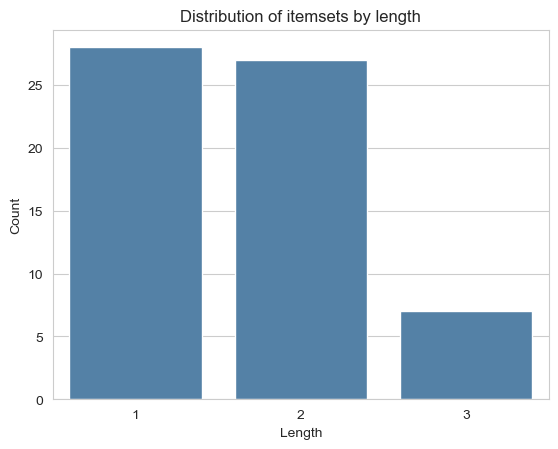

In [102]:
# Plot graph
sns.set_style("whitegrid")
plt.figure()
sns.countplot(x="length", data=itemsets, color="steelblue")
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of itemsets by length')
plt.show()

The Apriori algorithm was applied to the encoded dataframe and this is the result. It provides us with the support in the first column followed by the itemsets and the number of items in the itemsets in their respective columns. 

<br>

## 4. Determine Association Rules

Association rules identify the relationship between the items we set out to find. The rules are of form: "IF [Item A] THEN [Item B]". The condition precedes the outcome of the action the customer takes next. The antecedent is the IF part of the rule, while the consequent is the THEN part. There are three matrices to help us measure the associations:

The Apriori function needs to be called before we get to this step. This is what we just finished doing.

In [103]:
# Gives us the association rules 
rules = association_rules(itemsets, metric="lift", min_threshold=1)

In [104]:
# View results with specified column names
rules1 = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules1.head()

,antecedents,consequents,support,confidence,lift
0,(Bombay Aloo),(Naan),0.094974,0.452277,1.331167
1,(Naan),(Bombay Aloo),0.094974,0.279533,1.331167
2,(Bombay Aloo),(Pilau Rice),0.112219,0.534399,1.255104
3,(Pilau Rice),(Bombay Aloo),0.112219,0.263560,1.255104
4,(Bombay Aloo),(Plain Papadum),0.080578,0.383721,1.172941


In [68]:
# Check shape
rules1.shape

(94, 5)

I stumbled on deciding what threshold to use for this problem and then decided on playing around with the thresholds. We're finding that there are significant combinations. Some questions I asked myself include: Do I want to select a higher number so that the result is a dataset with a number of baskets that are easy to manage or do I choose a lower threshold that way I have more input for the marketing team? 

Example: a confidence of 45% of the second row means that over 4 out of 10 order transactions with Bombay Aloo included naan. 

We're finding that the association rules with higher lift, confidence, and support are the strongest.

In [105]:
# Gives us the association rules 
rules2 = association_rules(itemsets, metric="confidence", min_threshold=0.7)

In [106]:
# View results where the confidence it is equal or higher than 1
rules2 = rules1[rules1['confidence'] >= 1]
rules2.head()

,antecedents,consequents,support,confidence,lift


There are no itemsets that meet the parameter of a confidence equal or higher to 1. Let's try again with a confidence measure of 0.7. Therefore the rules that results from the above are not significant to us because the associations are not likely to occur when the lift metric is below 1.

In [107]:
rules2 = rules1[rules1['confidence'] >= 0.7]
rules2.head()

,antecedents,consequents,support,confidence,lift
27,(Mango Chutney),(Plain Papadum),0.149659,0.856477,2.618043
30,(Mint Sauce),(Plain Papadum),0.099552,0.783427,2.394745
43,(Onion Chutney),(Plain Papadum),0.077068,0.834711,2.551507
50,(Red Sauce),(Plain Papadum),0.062417,0.844460,2.581308
65,"(Mint Sauce, Mango Chutney)",(Plain Papadum),0.051633,0.907060,2.772661


In [108]:
rules2.shape

(8, 5)

We find 8 itemsets that meet our parameter.

In order to identify which items are bound together, we cannot relay on the support measure. We need to take a look at the confidence and the lift for this. 

### Applying the Apriori algorithm with different thresholds

In [109]:
# Apply Apriori algorithm to dataset
itemsets = apriori(orders_df, min_support=0.01, use_colnames=True)

In [110]:
# View results
itemsets.head()

,support,itemsets
0,0.011497,(Aloo Chaat)
1,0.013175,(Aloo Dupiaza)
2,0.040899,(Aloo Gobi)
3,0.018110,(Bhindi Bhajee)
4,0.032557,(Bhuna)


In [111]:
itemsets.shape

(745, 2)

In [116]:
# Find length, the number of items in each itemset
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets.head(10)

,support,itemsets,length
0,0.209991,(Bombay Aloo),1
1,0.077068,(Butter Chicken),1
2,0.068115,(Chapati),1
3,0.051226,(Chicken Tikka),1
4,0.066487,(Chicken Tikka (Main)),1
5,0.177383,(Chicken Tikka Masala),1
6,0.051124,(Curry),1
7,0.199410,(Garlic Naan),1
8,0.125293,(Keema Naan),1
9,0.083834,(Korma),1


In [117]:
# Apply Apriori algorithm to dataset
itemsets = apriori(orders_df, min_support=0.05, use_colnames=True)

In [118]:
# Count the number of itemsets
apriori(orders_df, min_support=0.01, use_colnames=True).count()

support     745
itemsets    745
dtype: int64

In [119]:
# Plot graph
sns.set_style("whitegrid")
plt.figure()
sns.countplot(x="length", data=itemsets, color="steelblue")
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of itemsets by length')
plt.show()

ValueError: Could not interpret input 'length'

After applying the Apriori algorithm to our dataset, I wasn't sure how to move forward.  I knew I wanted to find the association rules but I found myself questioning what would make the associations significant and what thresholds to use for the measures. "

In [ ]:
# Gives us the association rules 
rules = association_rules(itemsets, metric="lift", min_threshold=1)

In [ ]:
# View results with specified column names
rules3 = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules3.head()

In [ ]:
# Check shape
rules3.shape

We can say that when chicken tikka masala has been ordered, there is a high chance that the customer will buy aloo gobi. From the table, we can. infer that there's a strong association when aloo gobi is the antecedent and chicken tikka masala is the consequent. In the second scenario, the confidence is higher while the support amd lift remin the same.

<br>